# Frozen Lake Monte Carlo Control

In [1]:
using ReinforcementLearning, PyPlot, Random

Firstly, we will define our environment. We will make it recognizable for the [<tt>ReinforcementLearning.jl</tt>]( https://juliareinforcementlearning.org/).

Let us start with predefined constants and functions:

In [2]:
#actions coded as :left => 1, :down => 2, :right => 3, :up => 4
#arrows are corresponding to actions
arrows = Dict(1 => '⇐', 2 => '⇓', 3 => '⇒', 4 => '⇑');

grid4x4= ['S' 'F' 'F' 'F';
        'F' 'H' 'F' 'H';
        'F' 'F' 'F' 'H';
        'H' 'F' 'F' 'G'];

grid8x8 =['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F';
        'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F';
        'F' 'F' 'F' 'H' 'F' 'F' 'F' 'F';
        'F' 'F' 'F' 'F' 'F' 'H' 'F' 'F';
        'F' 'F' 'F' 'H' 'F' 'F' 'F' 'F';
        'F' 'H' 'H' 'F' 'F' 'F' 'H' 'F';
        'F' 'H' 'F' 'F' 'H' 'F' 'H' 'F';
        'F' 'F' 'F' 'H' 'F' 'F' 'F' 'G';];

In [3]:
#Auxilliary functions
function get_grid(dim, p_holes, seed = 234)
    Random.seed!(seed)
    grid = [rand() < p_holes ? 'H' : 'F' for i in 1:dim, j in 1:dim]
    grid[1,1] = 'S'
    grid[end,end] = 'G'
    return grid
end

function random_policy(grid,actions = actions)
    P = rand(Int,size(grid))
    for i = 1:length(grid)
        P[i] = rand(1:length(actions))
    end
    return P
end

function print_policy(P, grid, arrows = arrows)
    Policy = rand(Char,size(grid))
    for i = 1:length(grid)
        if grid[i] == 'F' || grid[i] == 'S' 
            Policy[i] = arrows[P[i]]
        elseif grid[i] == 'H' 
            Policy[i] = '⦷'
        else
            Policy[i] = grid[i]
        end
    end
    return Policy
end

print_policy (generic function with 2 methods)

#Now, we will define the environment as a mutable struct:


In [4]:

mutable struct FrozenLakeEnv <: AbstractEnv
    reward::Union{Nothing, Float64}
    rewards::Dict{Char, Float64} 
    actions::Dict{Int64, Tuple{Int64, Int64}}  
    world::Matrix{Char} 
    ES::Bool 
    position::Int 
end
Main.FrozenLakeEnv

FrozenLakeEnv

and define a constructor function of Frozen Lake environment:

In [5]:
function FrozenLakeEnv(grid::Union{Int,Symbol} = :grid4x4; ES::Bool = false) 
    if typeof(grid) == Int
        world = get_grid(grid, 0.1)
    elseif grid == :grid4x4
        world = grid4x4
    elseif grid == :grid8x8
        world = grid8x8
    else
        @error "unknown grid"
    end
    ES == true ? position = rand(1:length(world)) : position = 1
    return FrozenLakeEnv(nothing, Dict('S' => -0.05, 'G' => 1.0, 'H' => -1.0, 'F' => -0.05),
    Dict(1 => (0,-1), 2 => (1,0), 3 => (0,1), 4 => (-1,0)), 
        world, ES, position)
    
end

FrozenLakeEnv

Now, we must define the minimal interface of the environment. Without this functions code will not work properly:

In [6]:
#functions:
RLBase.action_space(env::FrozenLakeEnv) = Base.OneTo(length(env.actions))
RLBase.state_space(env::FrozenLakeEnv) = Base.OneTo(length(env.world))
RLBase.reward(env::FrozenLakeEnv) = env.reward
RLBase.state(env::FrozenLakeEnv) = env.position
RLBase.is_terminated(env::FrozenLakeEnv) = env.reward == 1.0 || env.reward == -1.0
function RLBase.reset!(env::FrozenLakeEnv) 
    env.reward = nothing
    env.ES == true ? env.position = rand(state_space(env)) : env.position = 1
end

and the most important function that controls the  movement:

In [7]:

function (x::FrozenLakeEnv)(action)
    @assert action in action_space(x)
    direction = x.actions[action]
    cartesian_state = (CartesianIndices(x.world)[x.position][1],
                        CartesianIndices(x.world)[x.position][2])
    sides = filter(y -> !(y in [direction, direction .* -1]), collect(values(x.actions)))
    p = rand()
    if p <= 0.8
        new_state = cartesian_state .+ direction
    elseif p <= 0.9
        new_state = cartesian_state .+ sides[1]
    else
        new_state = cartesian_state .+ sides[2]
    end
    if new_state[1] in (1:size(x.world,1)) && new_state[2] in (1:size(x.world,2))
        x.position = LinearIndices(x.world)[new_state[1],new_state[2]]
        x.reward = x.rewards[x.world[x.position]]
    else
        x.position = LinearIndices(x.world)[cartesian_state[1],cartesian_state[2]]
        x.reward = x.rewards[x.world[x.position]]
    end
end

Now we could test if the Frozen Lake enviroment works and debug it if neccessary:

In [8]:
env = FrozenLakeEnv(:grid8x8, ES = false);
RLBase.test_runnable!(env);

Test Summary:                    | Pass  Total  Time
random policy with FrozenLakeEnv | 2000   2000  0.0s


[Hooks](https://juliareinforcementlearning.org/docs/How_to_use_hooks/) are one of the biggest advantages of the <tt>ReinforcementLearning.jl</tt> package. They allow us to collect some useful information about the training process. Here is the simple example how we could use them:

In [9]:
hook = TotalRewardPerEpisode()
TotalRewardPerEpisode(Float64[], 0.0, true)

TotalRewardPerEpisode(Float64[], 0.0, true)

In [10]:
run(RandomPolicy(action_space(env)), env, StopAfterEpisode(200_000), hook)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


             ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
             ┌────────────────────────────────────────┐ 
          10 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀│ 
             │⣿⣿⣯⣯⣿⣿⣿⣿⣯⣿⣿⣭⣽⣽⣿⣿⣭⣽⣯⣯⣿⣿⣽⣭⣿⣯⣭⣯⣭⣯⣿⣿⣿⣿⣽⣿⣿⣿⣿⣿│ 
             │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
   Score     │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
             │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
             │⣿⣿⣿⣿⣿⢿⣿⣿⣿⣿⣿⡏⣿⣿⣿⡿⣿⡏⣿⠟⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⡿⣿⣿⡿⣿⣿⣿⠿⣿│ 
             │⠉⡿⣿⠈⠁⠸⠋⢸⠈⠸⢹⠁⠋⢿⠈⠁⠇⡇⣿⠀⠈⢿⠉⠟⣿⣿⡿⡟⠀⠉⠸⠁⠏⠟⡇⠃⢿⢸⠀⢹│ 
             │⠀⠀⢸⠀⠀⠀⠀⠘⠀⠀⠸⠀⠀⠘⠀⠀⠀⠃⡏⠀⠀⠀⠀⠀⠀⠘⠁⠁⠀⠀⠀⠀⠀⠀⠇⠀⠀⠀⠀⠈│ 
             │⠀⠀⠸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -20 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             └─────────────────

TotalRewardPerEpisode([-1.8000000000000003, -1.85, -2.650000000000001, -4.199999999999997, -1.9000000000000004, -2.8000000000000007, -2.4500000000000006, -5.049999999999994, -1.75, -1.35  …  -2.4000000000000004, -2.500000000000001, -2.500000000000001, -2.1000000000000005, -2.650000000000001, -1.45, -3.0500000000000007, -1.3, -1.45, -1.8000000000000003], 0.0, true)

or in a more sophisticated case:

In [11]:
mcpolicy = QBasedPolicy(
           learner = MonteCarloLearner(
                   approximator=TabularQApproximator(
                       ;n_state = length(state_space(env)),
                       n_action = length(action_space(env)),
                        init = 0.0,
                   ),
            γ = 0.999
               ),
           explorer = EpsilonGreedyExplorer(0.1)
       )

typename(QBasedPolicy)
├─ learner => typename(MonteCarloLearner)
│  ├─ approximator => typename(TabularApproximator)
│  │  ├─ table => 4×64 Matrix{Float64}
│  │  └─ optimizer => typename(Flux.Optimise.InvDecay)
│  │     ├─ gamma => 1.0
│  │     └─ state => typename(IdDict)
│  ├─ γ => 0.999
│  ├─ kind => typename(ReinforcementLearningZoo.FirstVisit)
│  └─ sampling => typename(ReinforcementLearningZoo.NoSampling)
└─ explorer => typename(EpsilonGreedyExplorer)
   ├─ ϵ_stable => 0.1
   ├─ ϵ_init => 1.0
   ├─ warmup_steps => 0
   ├─ decay_steps => 0
   ├─ step => 1
   ├─ rng => typename(Random._GLOBAL_RNG)
   └─ is_training => true


In [12]:
run(mcpolicy, env, StopAfterEpisode(200_000), hook)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠿⡿⠿⠿⠿⠿⠿⠿⠿⠟⠿⠿⠿⠿⠻⠿⠿⠿⠿⠻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
   Score      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⢹⡏⣿⠿⡏⣿⠿⣿⣿⣿⣿⠿⢻⣿⣿⢹⣿⣿⣿│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠉⠀⠁⠈⠀⠋⠁⢿⡏⠀⢸⠘⠉⠘⡿⡿⠛│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠀⠈⠀⠀⠀⠇⠁⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -200 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

TotalRewardPerEpisode([-1.8000000000000003, -1.85, -2.650000000000001, -4.199999999999997, -1.9000000000000004, -2.8000000000000007, -2.4500000000000006, -5.049999999999994, -1.75, -1.35  …  -4.7999999999999945, -39.249999999999964, -8.099999999999984, -16.400000000000084, -7.249999999999986, -11.550000000000015, -18.20000000000011, -12.850000000000033, -26.65000000000023, -7.649999999999984], 0.0, true)

In [13]:
agentMC = Agent(
           policy = mcpolicy,
           trajectory = VectorSARTTrajectory()
       )

typename(Agent)
├─ policy => typename(QBasedPolicy)
│  ├─ learner => typename(MonteCarloLearner)
│  │  ├─ approximator => typename(TabularApproximator)
│  │  │  ├─ table => 4×64 Matrix{Float64}
│  │  │  └─ optimizer => typename(Flux.Optimise.InvDecay)
│  │  │     ├─ gamma => 1.0
│  │  │     └─ state => typename(IdDict)
│  │  ├─ γ => 0.999
│  │  ├─ kind => typename(ReinforcementLearningZoo.FirstVisit)
│  │  └─ sampling => typename(ReinforcementLearningZoo.NoSampling)
│  └─ explorer => typename(EpsilonGreedyExplorer)
│     ├─ ϵ_stable => 0.1
│     ├─ ϵ_init => 1.0
│     ├─ warmup_steps => 0
│     ├─ decay_steps => 0
│     ├─ step => 54478652
│     ├─ rng => typename(Random._GLOBAL_RNG)
│     └─ is_training => true
└─ trajectory => typename(Trajectory)
   └─ traces => typename(NamedTuple)
      ├─ state => 0-element Vector{Int64}
      ├─ action => 0-element Vector{Int64}
      ├─ reward => 0-element Vector{Float32}
      └─ terminal => 0-element Vector{Bool}


In [14]:
run(agentMC, env, StopAfterEpisode(200_000), hook)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⡀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀│ 
              │⢿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠋⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   Score      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢿⣿⢿⢿⢹⢿⣿⣿⡿⣿⣿⢹⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠈⠈⠈⠘⠁⢿⠁⢹⠋⢸⣿⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠈⠀⠸⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -200 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

TotalRewardPerEpisode([-1.8000000000000003, -1.85, -2.650000000000001, -4.199999999999997, -1.9000000000000004, -2.8000000000000007, -2.4500000000000006, -5.049999999999994, -1.75, -1.35  …  -1.8000000000000003, 0.04999999999999971, -1.85, -1.75, 0.1499999999999998, -1.65, -1.4, -1.65, 0.2499999999999999, -2.220446049250313e-16], 0.0, true)

After learning how to build agents with the [<tt>ReinforcementLearning.jl</tt>]( https://juliareinforcementlearning.org/) package, we could implement our own agent and understand the logic of the Monte Carlo algorithm:

In [16]:
mutable struct AgentMC
    env::FrozenLakeEnv
    ϵ::Float64
    β::Float64 #stopa dyskonta
    Q::Array{Float64,2}#macierz wartosci dla kazdej z par:stan,akcja
    C::Array{Float64,2} #macierz wystapien dla kazdej z par:stan,akcja
    π::Array{Int} #strategia agenta
end

function AgentMC(env; ϵ = .2, β = 0.999)
    return AgentMC(env,ϵ, β,
        zeros(length(env.world), length(action_space(env))), 
        zeros(length(env.world), length(action_space(env))),
        rand(1:length(action_space(env)),length(env.world)))
end

AgentMC

Now, we could implement the logic of the learning process:

In [17]:
function get_episode(agent, π = agent.π; maxstep = 1000)
    step = 1
    if agent.env.ES == true 
        S = rand(state_space(agent.env)) 
        action = rand(action_space(agent.env))
    else
        S = 1
        rand() < agent.ϵ ? action = rand(action_space(agent.env)) : action = π[S]
    end
    agent.env(action)
    r = agent.env.reward
    episode = [(S, action, r)]
    if is_terminated(agent.env) 
        reset!(agent.env)
        return episode
    end
    while step < maxstep
        S = state(agent.env)
        (rand() < agent.ϵ) && (agent.env.ES == false) ? action = rand(action_space(agent.env)) : action = π[S]
        agent.env(action)
        r = agent.env.reward
        push!(episode, (S, action,r))
        if is_terminated(agent.env)
            reset!(agent.env)
            break
        end
        step +=1
    end
    return episode
end

get_episode (generic function with 2 methods)

In [18]:
function update!(agent)
    episode = get_episode(agent)
    R = 0
    occur_first = reverse(vcat(findfirst.(isequal.(unique(episode)), [episode]), length(episode) + 1))
    for k = 2:length(occur_first)
        for i = occur_first[k-1] - 1:-1:occur_first[k]
            state,action,r = episode[i]
            R = agent.β*R + r
        end
        state,action,r = episode[occur_first[k]]
        agent.C[state,action] += 1
        agent.Q[state,action] += (R - agent.Q[state,action])/ agent.C[state,action]
        agent.π[state] = argmax(agent.Q[state,:])
    end  
    episode[end][3] == 1.0 ? (return 1.0) : (return 0.0)
end

update! (generic function with 1 method)

In [19]:
function MC!(agent; maxit = 100000)
    iter = 0
    successes = 0.0
    success_rate = []
    while iter < maxit
        successes += update!(agent)
        push!(success_rate, successes/iter)
        iter +=1
    end
    return success_rate
end

MC! (generic function with 1 method)

Finally, we could run the experiments and take a look at the results:

In [39]:
#xploring starts 
agent = AgentMC(FrozenLakeEnv(:grid4x4, ES = true));
MC!(agent, maxit = 500_000)
print_policy(agent.π, agent.env.world)

4×4 Matrix{Char}:
 '⇓'  '⇒'  '⇓'  '⇐'
 '⇓'  '⦷'  '⇓'  '⦷'
 '⇒'  '⇒'  '⇓'  '⦷'
 '⦷'  '⇒'  '⇒'  'G'

In [40]:
#without exploring starts
agent = AgentMC(FrozenLakeEnv(:grid4x4, ES = false));
success_rate = MC!(agent; maxit = 500_000)
print_policy(agent.π, agent.env.world)

4×4 Matrix{Char}:
 '⇓'  '⇒'  '⇓'  '⇐'
 '⇓'  '⦷'  '⇓'  '⦷'
 '⇒'  '⇓'  '⇓'  '⦷'
 '⦷'  '⇒'  '⇒'  'G'

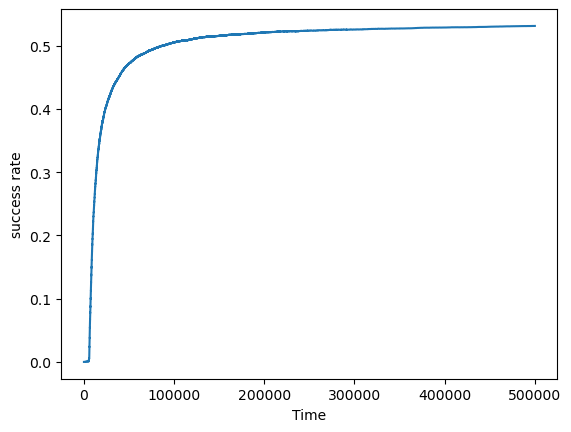

PyObject Text(24.000000000000007, 0.5, 'success rate')

In [41]:
plot(success_rate[2:end])
xlabel("Time")
ylabel("success rate")